LSTM GRU for text generation.

Inaya Rahmanisa


References:
- Tutorial LSTM from scratch by Pak Alfan Farizki Wicaksono, Fasilkom UI
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://arxiv.org/pdf/1406.1078v3
- https://d2l.ai/chapter_recurrent-modern/gru.html

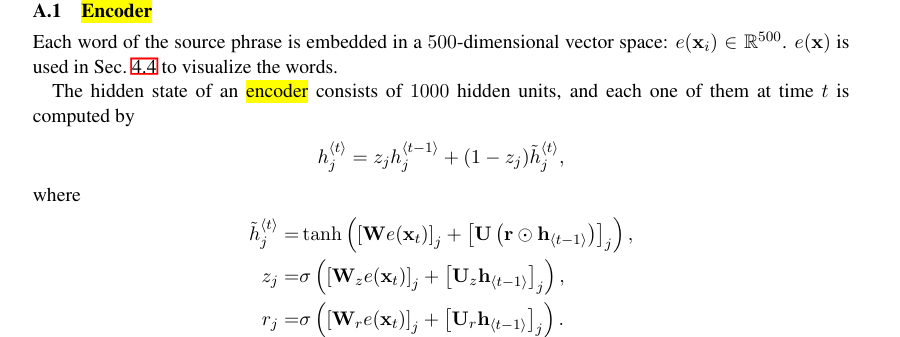

- GRU doesn’t contain a cell state
- It Contains only 2 gates(Reset and Update Gate)
- In this example, bias is not used

In [53]:
import torch
import pandas as pd
import numpy as np

from collections import Counter
from torch import nn, optim
from torch.utils.data import DataLoader

In [54]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sequence_length,
        documents, # list of strings
    ):
        self.sequence_length = sequence_length
        self.words = self.load_words(documents)
        print(self.words)
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self, documents):
        text = ""
        for doc in documents:
          text += doc + " "
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

In [55]:
class Linear(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = nn.Parameter(torch.Tensor(self.n_inputs, self.n_outputs))
        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            nn.init.uniform_(param, -0.1, 0.1)

    def forward(self, x):
        return x @ self.W

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Update gate components
        self.W_iz = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        # self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        # Reset gate components
        self.W_ir = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hr = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        # self.b_f = nn.Parameter(torch.Tensor(hidden_size))

       # output
        self.W_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        # self.b_g = nn.Parameter(torch.Tensor(hidden_size))


        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            nn.init.uniform_(param, -0.1, 0.1)

    def forward(self, x, hidden):
        h_prev = hidden

        z_t = torch.sigmoid(x @ self.W_iz.T + h_prev @ self.W_hz.T)
        r_t = torch.sigmoid(x @ self.W_ir.T + h_prev @ self.W_hr.T)
        hTilde_t = torch.tanh(x @ self.W_ih.T + (h_prev * r_t) @ self.W_hh.T)
        h_t = (1-z_t) * hTilde_t + z_t * h_prev


        return (h_t)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.cell = GRUCell(input_size, hidden_size)

    def forward(self, x, prev_state):
        batch_size, seq_len, _ = x.size()
        h = prev_state

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            h = self.cell(x_t, h)
            outputs.append(h)

        return torch.stack(outputs, dim=1), h

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.gru_size = 16
        self.embedding_dim = 16
        self.n_vocab = len(dataset.uniq_words)

        self.embedding = nn.Embedding(
            num_embeddings=self.n_vocab,
            embedding_dim=self.embedding_dim
        )
        self.gru = GRU(
            input_size=self.embedding_dim,
            hidden_size=self.gru_size
        )
        self.fc = Linear(self.gru_size, self.n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, h = self.gru(embed, prev_state)
        logits = self.fc(output)
        return logits, h

    def init_state(self, batch_size):
        return (torch.zeros(batch_size, self.gru_size))

def train(dataset, model, batch_size, max_epochs=400):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        h = model.init_state(batch_size) #hidden state awal, NOL

        for batch, (x, y) in enumerate(dataloader):
            y_pred, h = model(x, h)
            loss = criterion(y_pred.transpose(1, 2), y)

            loss.backward()
            optimizer.step()

            #h_state detached from current graph; tapi isi tetap sama agar berlanjut (statefull)
            #graph batch sekarang jangan nyambung dengan batch berikutnya; tetapi nilai
            #h_state harus berlanjut dari satu batch ke batch berikutnya. Caranya adalah
            #dengan detach() ini.
            h = h.detach()

            optimizer.zero_grad()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

def predict(dataset, model, text, next_words=20):
    model.eval()

    words = text.split(' ')
    h_state = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, h_state = model(x, h_state)

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()

        # random choice
        word_index = np.random.choice(len(last_word_logits), p=p)
        # word_index = np.argmax(p)

        words.append(dataset.index_to_word[word_index])

    return words

In [56]:
documents = ["saya pergi ke depok",
             "di depok makan sayuran",
             "dan buah nangka yang segar",
             "angin bertiup kencang",
             "tanda hujan akan turun di jalan margonda"]

dataset = Dataset(2, documents)
dataloader = DataLoader(dataset, batch_size=2)
for batch, (xs, ys) in enumerate(dataloader):
  print(xs)
  print(ys)

['saya', 'pergi', 'ke', 'depok', 'di', 'depok', 'makan', 'sayuran', 'dan', 'buah', 'nangka', 'yang', 'segar', 'angin', 'bertiup', 'kencang', 'tanda', 'hujan', 'akan', 'turun', 'di', 'jalan', 'margonda', '']
tensor([[2, 3],
        [3, 4]])
tensor([[3, 4],
        [4, 0]])
tensor([[4, 0],
        [0, 1]])
tensor([[0, 1],
        [1, 0]])
tensor([[1, 0],
        [0, 5]])
tensor([[0, 5],
        [5, 6]])
tensor([[5, 6],
        [6, 7]])
tensor([[6, 7],
        [7, 8]])
tensor([[7, 8],
        [8, 9]])
tensor([[ 8,  9],
        [ 9, 10]])
tensor([[ 9, 10],
        [10, 11]])
tensor([[10, 11],
        [11, 12]])
tensor([[11, 12],
        [12, 13]])
tensor([[12, 13],
        [13, 14]])
tensor([[13, 14],
        [14, 15]])
tensor([[14, 15],
        [15, 16]])
tensor([[15, 16],
        [16, 17]])
tensor([[16, 17],
        [17, 18]])
tensor([[17, 18],
        [18,  1]])
tensor([[18,  1],
        [ 1, 19]])
tensor([[ 1, 19],
        [19, 20]])
tensor([[19, 20],
        [20, 21]])


In [57]:
dataset = Dataset(2, documents)
model = Model(dataset)

train(dataset, model, 2)

['saya', 'pergi', 'ke', 'depok', 'di', 'depok', 'makan', 'sayuran', 'dan', 'buah', 'nangka', 'yang', 'segar', 'angin', 'bertiup', 'kencang', 'tanda', 'hujan', 'akan', 'turun', 'di', 'jalan', 'margonda', '']
{'epoch': 0, 'batch': 0, 'loss': 3.0694737434387207}
{'epoch': 0, 'batch': 1, 'loss': 3.1001076698303223}
{'epoch': 0, 'batch': 2, 'loss': 3.0987751483917236}
{'epoch': 0, 'batch': 3, 'loss': 3.103759288787842}
{'epoch': 0, 'batch': 4, 'loss': 3.0767111778259277}
{'epoch': 0, 'batch': 5, 'loss': 3.1190311908721924}
{'epoch': 0, 'batch': 6, 'loss': 3.0750231742858887}
{'epoch': 0, 'batch': 7, 'loss': 3.088646411895752}
{'epoch': 0, 'batch': 8, 'loss': 3.0668585300445557}
{'epoch': 0, 'batch': 9, 'loss': 3.0824294090270996}
{'epoch': 0, 'batch': 10, 'loss': 3.0837717056274414}
{'epoch': 1, 'batch': 0, 'loss': 3.0445058345794678}
{'epoch': 1, 'batch': 1, 'loss': 3.0840189456939697}
{'epoch': 1, 'batch': 2, 'loss': 3.0842537879943848}
{'epoch': 1, 'batch': 3, 'loss': 3.0851738452911377}

In [58]:
predict(dataset, model, "saya pergi", next_words=20)

['saya',
 'pergi',
 'ke',
 'depok',
 'di',
 'depok',
 'makan',
 'sayuran',
 'buah',
 'sayuran',
 'dan',
 'buah',
 'nangka',
 'yang',
 'segar',
 'angin',
 'bertiup',
 'kencang',
 'tanda',
 'hujan',
 'akan',
 'turun']